In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_tramites_proc_X = pd.read_parquet('./data/tramita/tramites_autoconsumo.parquet')

# dejamos solo las 3 columnas necesarias
columns_estados = ['id_exp','num_tramite','fecha_tramite']
df_estados_proc_X = df_tramites_proc_X[columns_estados]

#asignamos fecha como nueva columna, quitándonos la hora
df_estados_proc_X = df_estados_proc_X.assign(fecha=df_estados_proc_X['fecha_tramite'].dt.date)
df_estados_proc_X.drop('fecha_tramite', axis = 1, inplace = True)

# quitamos duplicados
df_estados_proc_X = df_estados_proc_X.drop_duplicates(
    subset=['id_exp', 'fecha', 'num_tramite'], 
    keep='last'
)


# puede haber varios cambios de estado es 1 día, hay que hacer una lista para cada expediente-dia de todos los estados por los que ha pasado
df_estados_proc_X = (
    df_estados_proc_X.reset_index()  # Reset index to access columns
    .sort_values(['id_exp', 'fecha'])  # Ensure proper sorting
    .groupby(['id_exp', 'fecha'])['num_tramite']
    .agg(list)  # Combine states into a list
    .reset_index()
    .set_index(['id_exp', 'fecha'])  # Restore MultiIndex
)

# rango de fechas completo
timeline = pd.date_range(df_estados_proc_X.index.get_level_values('fecha').min(),
                         df_estados_proc_X.index.get_level_values('fecha').max())


# Create a MultiIndex with all combinations of id_exp and timeline
multi_index = pd.MultiIndex.from_product(
    [df_estados_proc_X.index.levels[0], timeline], names=['id_exp', 'fecha']
)

# Reindex to this complete MultiIndex
df_estados_proc_X_reindexed = df_estados_proc_X.reindex(multi_index)

# rellenamos la fecha entre estados con el estado anterior
df_estados_proc_X_reindexed['num_tramite'] = df_estados_proc_X_reindexed['num_tramite'].groupby(level=0).ffill()

# expandimos la lista de estados por día para generar una línea por cada estado en la misma fecha
df_estados_proc_X_exploded = df_estados_proc_X_reindexed.explode('num_tramite')

result = (
    df_estados_proc_X_exploded.reset_index()
    .groupby(['fecha', 'num_tramite'])
    .size()
    .unstack(fill_value=0)
)

In [7]:
result

num_tramite,0,1,10,21,30,41,42,50,51,52,...,70,82,90,100,152,278,283,286,287,309
fecha,,,,,,,,,,,,,,,,,,,,,
2021-12-22,317,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-23,599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-24,723,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-25,745,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-26,797,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-22,2434,15200,514,0,961,21,895,3936,403,383,...,3257,53,0,678,19,7,1,34,851,2
2024-08-23,2429,15179,510,0,989,21,920,3892,403,384,...,3295,56,0,678,21,7,1,35,851,2
2024-08-24,2429,15179,510,0,989,21,920,3892,403,384,...,3295,56,0,678,21,7,1,35,851,2


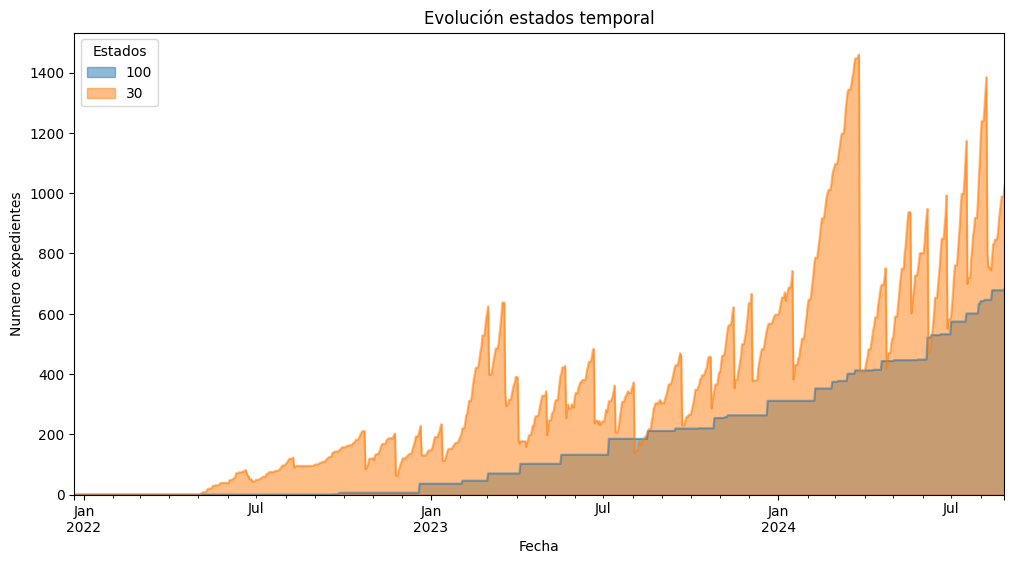

In [8]:
column_states = [100,30]
df_toplot = result[column_states]

# Step 7: Plot
df_toplot.plot(kind="area", stacked=False, figsize=(12, 6))
plt.title("Evolución estados temporal")
plt.xlabel("Fecha")
plt.ylabel("Numero expedientes")
plt.legend(title="Estados")
plt.show()